In [2]:
# upgarde pip and install requirements
!/opt/conda/bin/python -m pip install --upgrade pip
!conda install graphviz
!pip install torchsummary
!pip install torchviz

     |████████████████████████████████| 1.5 MB 16.5 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.3
    Uninstalling pip-20.3.3:
      Successfully uninstalled pip-20.3.3


In [248]:
import torch
from torchviz import make_dot, make_dot_from_trace
from graphviz import Digraph
from collections import namedtuple
import gym
import gym_minipacman
from common.utils import *
from common.multiprocessing_env import SubprocVecEnv
from common.actor_critic import  OnPolicy, ActorCritic
from common.environment_model import EnvModel
from common.i2a import I2A, ImaginationCore

In [16]:
mode = 'regular'
env_id = '{}MiniPacmanNoFrameskip-v0'.format(mode.capitalize())
num_envs = 1
envs = SubprocVecEnv([make_env(env_id, i) for i in range(num_envs)])
state = envs.reset()
state = FloatTensor(state)
state_shape = envs.observation_space.shape
input_shape = (num_envs, *state_shape)
dummy_input = torch.randn(*input_shape).requires_grad_(True)

In [219]:
actor_critic = ActorCritic(envs.observation_space.shape, envs.action_space.n)
inputs = torch.zeros(*input_shape, dtype=torch.float, requires_grad=False)
flow = actor_critic(inputs)


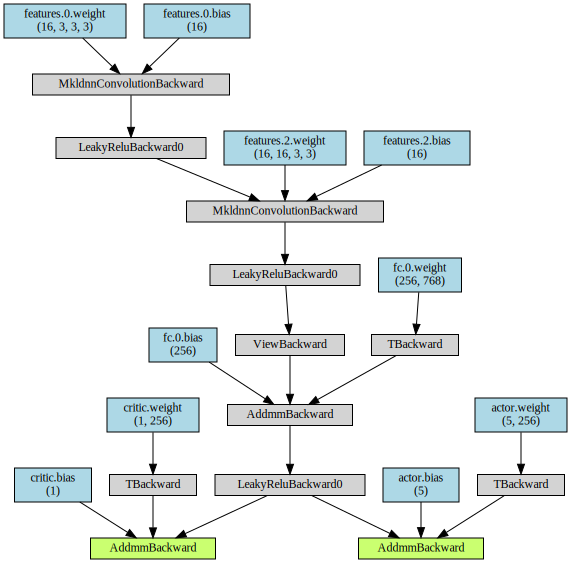

In [9]:
dot = make_dot(flow, params=dict(actor_critic.named_parameters()))
#dot.format = 'png'
#dot.render('images/actor_critic_graph_image')
make_dot(flow, params=dict(actor_critic.named_parameters()))

In [242]:
env_model = EnvModel((8,15,19), 8)
env_inputs = torch.zeros(1,8,15,19, dtype=torch.float, requires_grad=False)
env_flow = env_model(env_inputs)

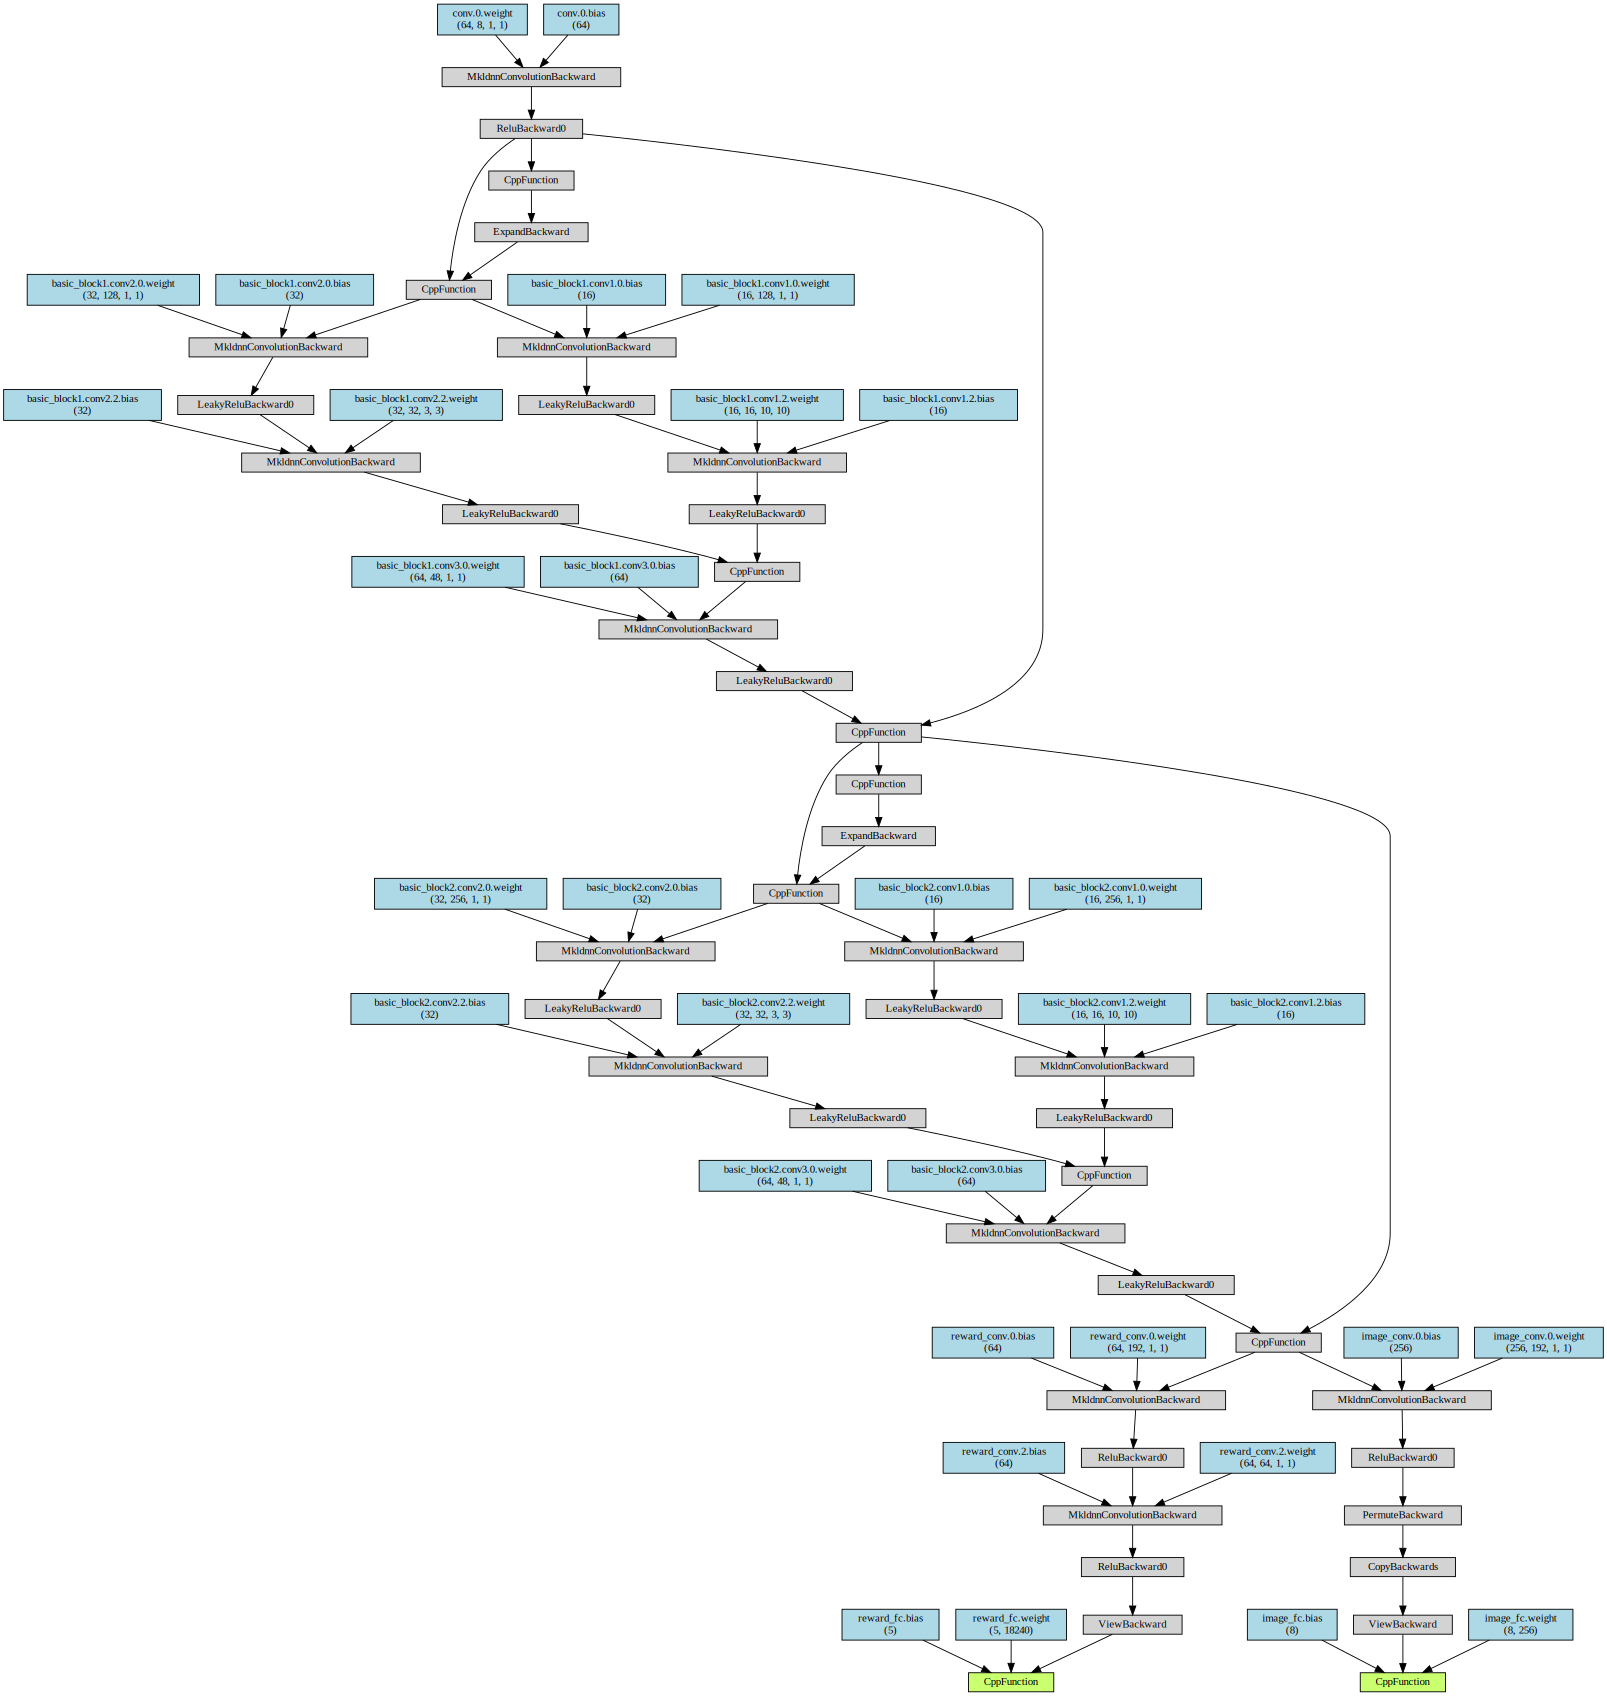

In [245]:
dot = make_dot(env_flow, params=dict(env_model.named_parameters()))
dot.format = 'png'
dot.render('images/env_model_graph_image')
make_dot(env_flow, params=dict(env_model.named_parameters()))

In [261]:
rollout_depth = 3
num_actions = 5
num_rewards = 5
distill_policy = actor_critic
imagination = ImaginationCore(rollout_depth, state_shape, num_actions, num_rewards, env_model.cuda(), distill_policy.cuda(), full_rollout=True)
i2a = I2A(state_shape, num_actions, num_rewards,  256, imagination, full_rollout=True)
i2a.cuda()

I2A(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
  )
  (encoder): RolloutEncoder(
    (features): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
      (3): LeakyReLU(negative_slope=0.01)
    )
    (gru): GRU(773, 256)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (critic): Linear(in_features=256, out_features=1, bias=True)
  (actor): Linear(in_features=256, out_features=5, bias=True)
)

In [265]:
i2a_inputs = torch.zeros(*input_shape, dtype=torch.float, requires_grad=False)
i2a_inputs = i2a_inputs.cuda()
i2a_flow = i2a(i2a_inputs)

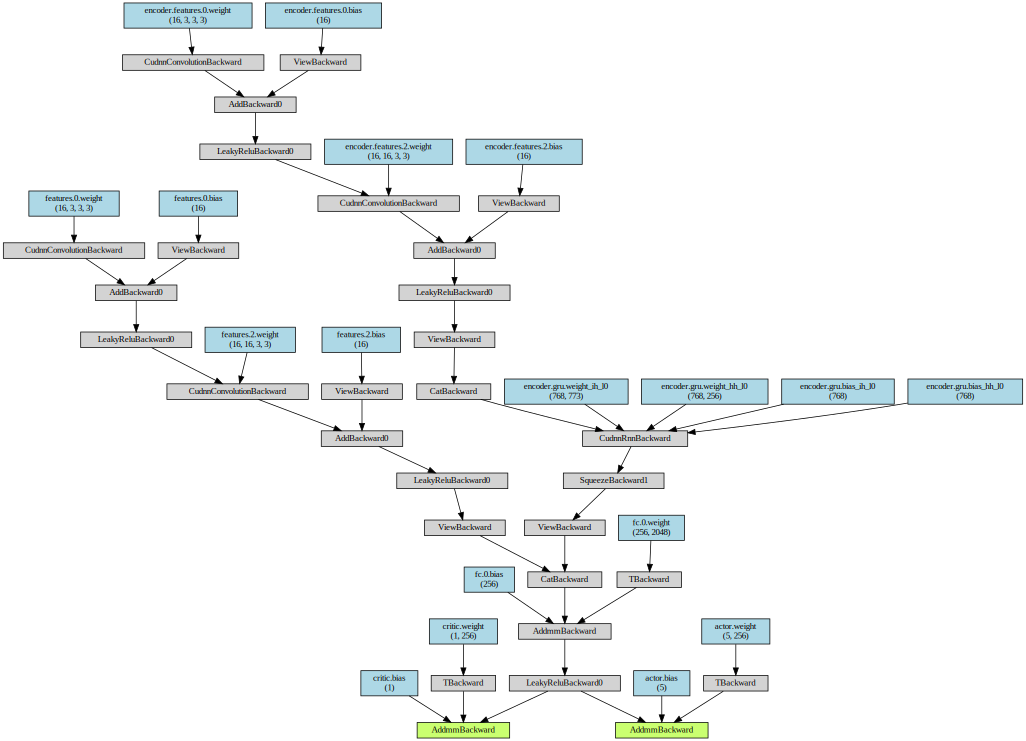

In [266]:
dot = make_dot(i2a_flow, params=dict(i2a.named_parameters()))
dot.format = 'png'
dot.render('images/i2a_graph_image')
make_dot(i2a_flow, params=dict(i2a.named_parameters()))